In [1]:
from car_finder import *
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Reading in Data

In [2]:
GTI_FOLDERS = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right']

gti_car_images_train = []
gti_car_images_test = []

for folder in GTI_FOLDERS:
    batch = glob.glob('vehicles/' + folder + '/*.png')
    sep_index = int(len(batch) * 0.2)
    gti_car_images_test = gti_car_images_test + batch[0: sep_index]
    gti_car_images_train = gti_car_images_train + batch[sep_index+1: len(batch)]
    
print(len(gti_car_images_train))
print(len(gti_car_images_test))

2260
562


In [3]:
kitti_car_images = glob.glob('vehicles/KITTI_extracted/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')

print(len(kitti_car_images))
print(len(noncar_images))

5966
12627


In [4]:
import csv
def augment_car_data():
    folder = 'object-dataset'
    csvfile = open(folder + "/labels.csv", "r")
    table = csv.reader(csvfile, delimiter=' ')
    current_img = None
    current_file = None
    for row in table:
        if row[0] != current_file:
            current_file = row[0]
            current_img = cv2.imread(folder + '/' + current_file)
        if row[6] == 'car':
            x_start = int(row[1])
            x_stop = int(row[3])
            y_start = int(row[2])
            y_stop = int(row[4])
            name = current_file.split('.')[0]
            area = current_img[y_start:y_stop, x_start:x_stop]
            if (area.shape[0] > 10 and area.shape[1] > 10):
                cropped = cv2.resize(area, (64, 64))
                cv2.imwrite('vehicles/Custom/{}_{}_{}.png'.format(name, x_start, y_start), cropped)
    csvfile.close()
    
# augment_car_data()

In [5]:
supplemental_car_images = glob.glob('vehicles/Custom/*.png')
print(len(supplemental_car_images))
supplemental_car_images = supplemental_car_images[0:1000]

60730


# Previewing data set

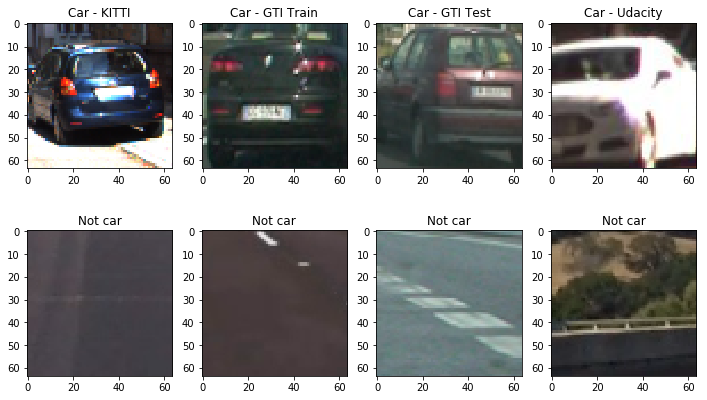

In [6]:
import random

f, plots = plt.subplots(nrows=2, ncols=4, figsize=(12, 7))
test_images_titles = ['Car - KITTI', 'Car - GTI Train', 'Car - GTI Test', 'Car - Udacity']
test_images = [kitti_car_images[random.randrange(len(kitti_car_images) - 1)],
               gti_car_images_train[random.randrange(len(gti_car_images_train) - 1)], 
               gti_car_images_test[random.randrange(len(gti_car_images_test) - 1)], 
               supplemental_car_images[random.randrange(len(supplemental_car_images) - 1)]]
for index, file in enumerate(test_images):
    img = plt.imread(file)
    plots[0][index].imshow(img)
    plots[0][index].set_title(test_images_titles[index])
    
    
for index in range(4):
    img = plt.imread(noncar_images[random.randrange(len(noncar_images) - 1)])
    plots[1][index].imshow(img)
    plots[1][index].set_title('Not car')
plt.show()

# Selecting HOG parameters for feature extraction

In [7]:
def plot_hog_preview(images, color_spaces, color_space_labels):
    for file in test_images:
        
        f, plots = plt.subplots(nrows=len(color_spaces), ncols=4, figsize=(10, len(color_spaces)*2))

        for row, color_space in enumerate(color_spaces):
            feature_image = cv2.imread(file)
            feature_image = cv2.cvtColor(feature_image, color_space)
        #     input_channel = cv2.equalizeHist(feature_image[:,:,0])
    #         clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            plots[row][0].imshow(feature_image)
            plots[row][0].set_ylabel(color_space_labels[row])
            for channel in range(3):
                input_channel = feature_image[:,:,channel]
    #             input_channel = clahe.apply(feature_image[:,:,channel])
                car_test_features, visual = get_hog_features(input_channel, orientations, 
                                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                plots[row][channel+1].imshow(visual)
        f.tight_layout()
        plt.show()

/Users/phu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


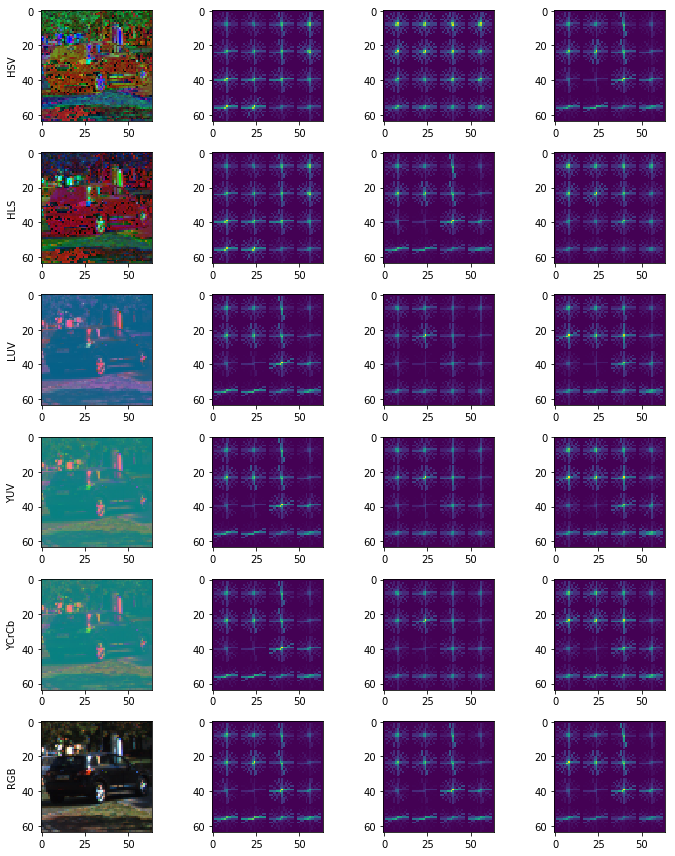

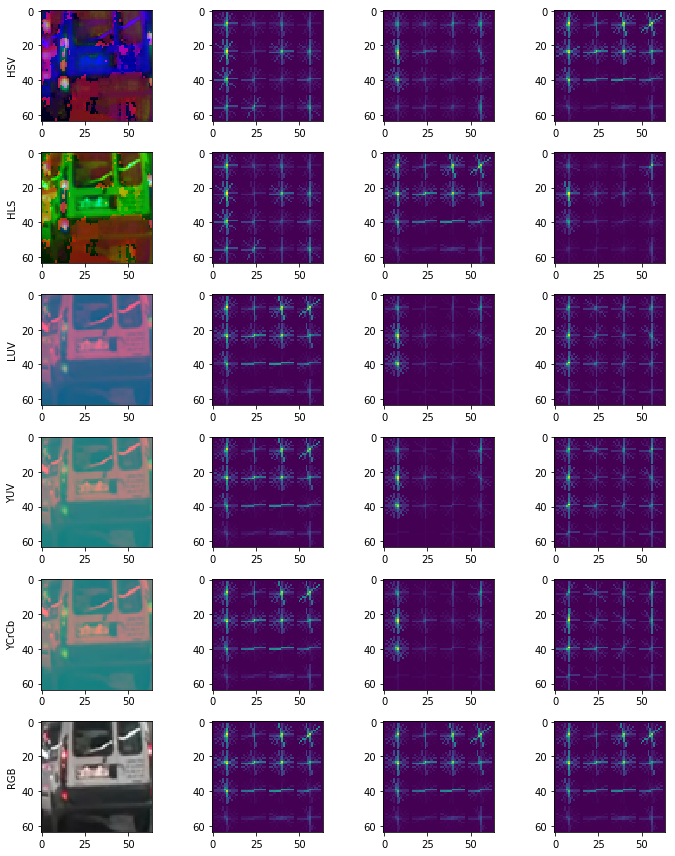

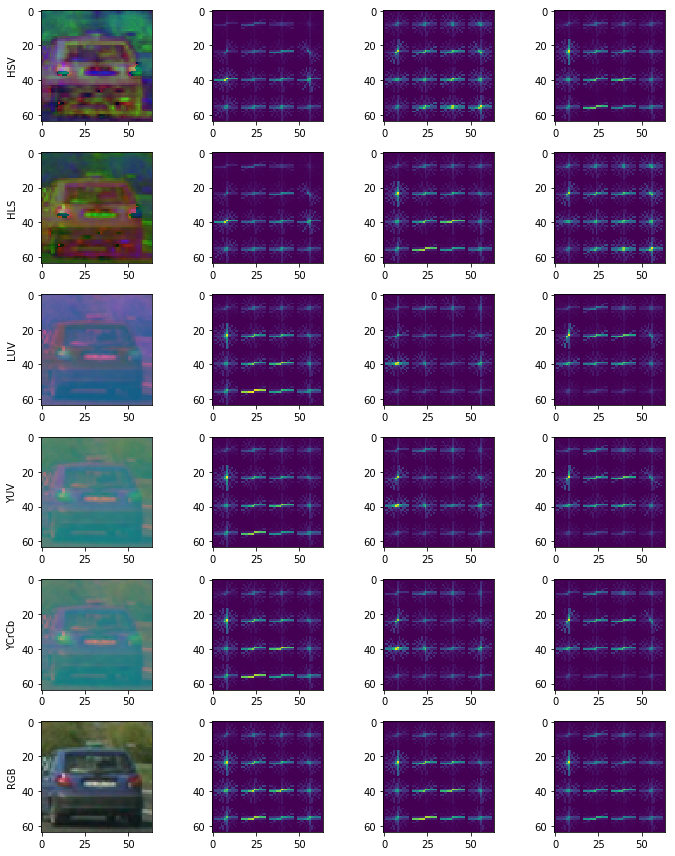

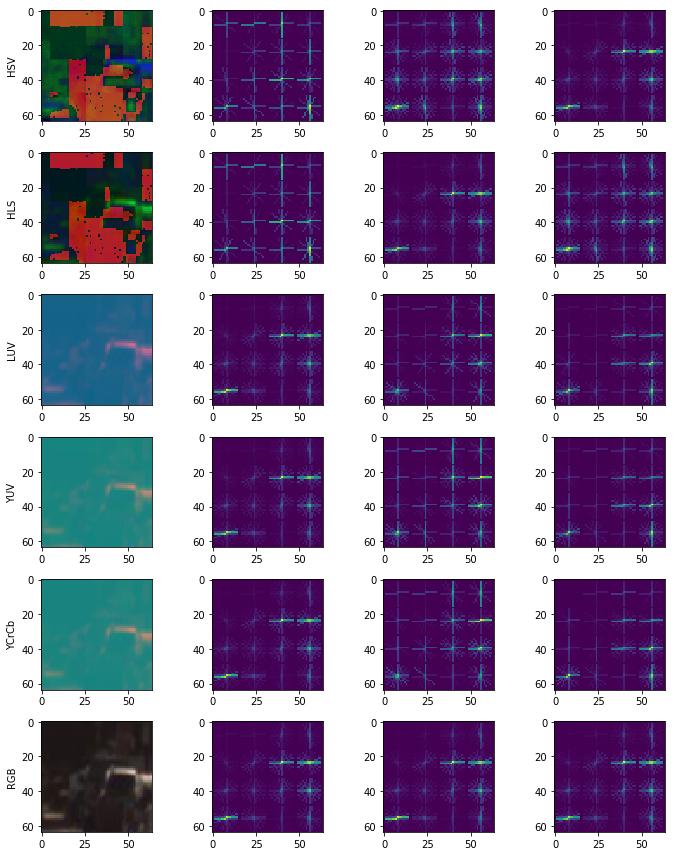

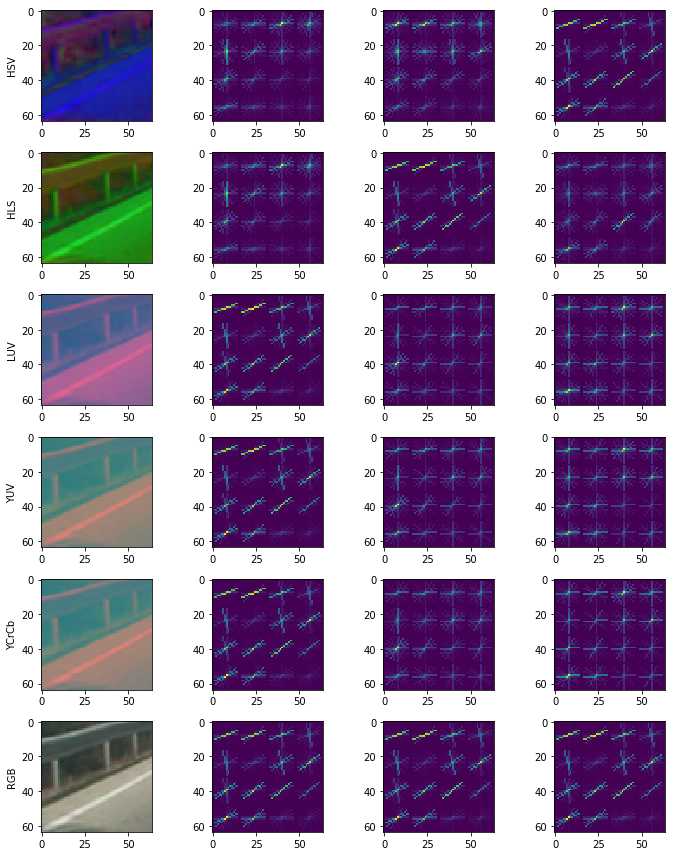

In [8]:
test_images = [kitti_car_images[len(kitti_car_images) - 1], 
               gti_car_images_train[len(gti_car_images_train) - 1], 
               gti_car_images_test[len(gti_car_images_test) - 1], 
               supplemental_car_images[len(supplemental_car_images) - 1],
               noncar_images[len(noncar_images) - 1]]


# Experimenting with color space
orientations = 11
pix_per_cell = 16
cell_per_block = 2

plot_hog_preview(test_images, color_spaces = [cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2HLS, 
                        cv2.COLOR_BGR2LUV, cv2.COLOR_BGR2YUV,
                        cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2RGB],
                        color_space_labels=['HSV', 'HLS', 'LUV', 'YUV', 'YCrCb', 'RGB'])
    


/Users/phu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


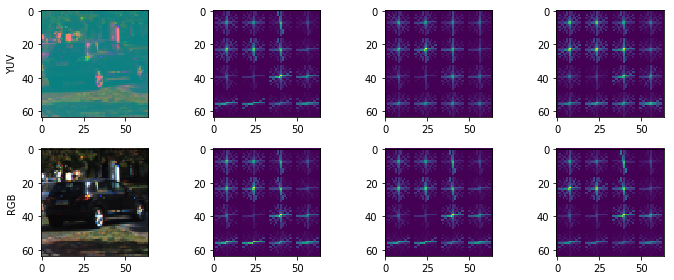

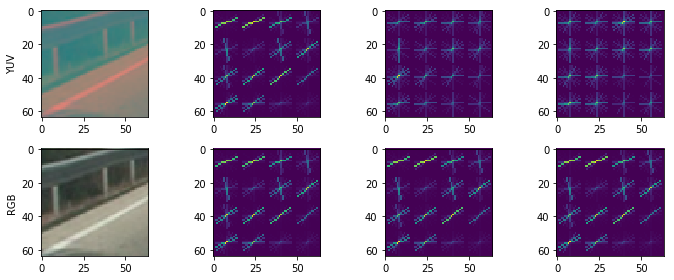

In [9]:
test_images = [kitti_car_images[len(kitti_car_images) - 1],
               noncar_images[len(noncar_images) - 1]]

plot_hog_preview(test_images, color_spaces = [ cv2.COLOR_BGR2YUV,
                        cv2.COLOR_BGR2RGB],
                        color_space_labels=['YUV', 'RGB'])

In [10]:
# Parameters for color histogram features
hist_bins = 32

In [11]:
def plot_hist_preview(images, color_spaces, color_space_labels, nbins):
    for file in test_images:
        f, plots = plt.subplots(nrows=len(color_spaces), ncols=4, figsize=(10, len(color_spaces)*2))
        for row, color_space in enumerate(color_spaces):
            feature_image = cv2.imread(file)
            feature_image = cv2.cvtColor(feature_image, color_space)
            plots[row][0].imshow(feature_image)
            plots[row][0].set_ylabel(color_space_labels[row])
            for channel in range(3):
                input_channel = feature_image[:,:,channel]
                plots[row][channel+1].hist(input_channel.ravel(), bins=nbins)
        f.tight_layout()
        plt.show()

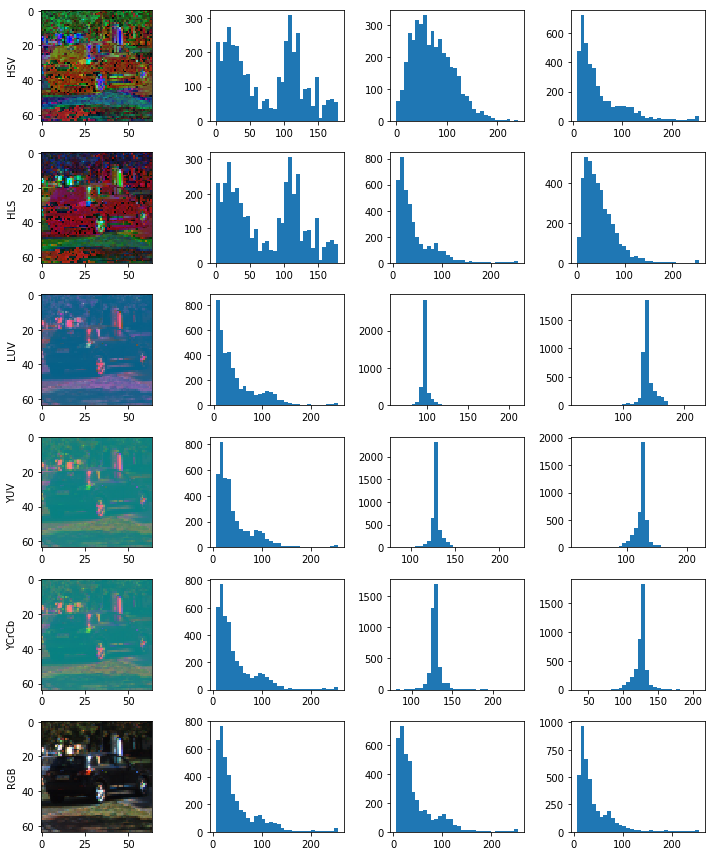

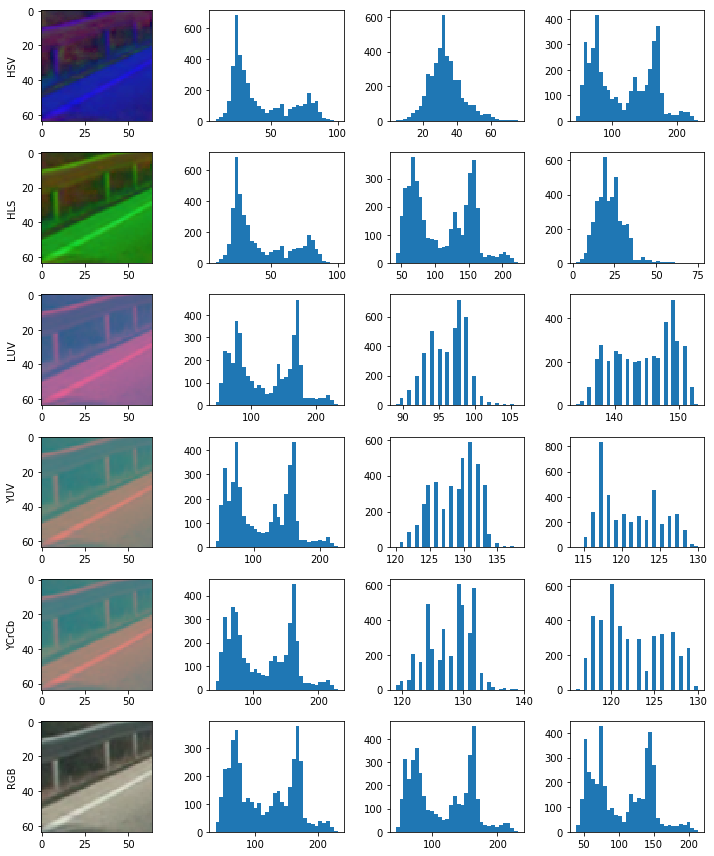

In [12]:
test_images = [kitti_car_images[len(kitti_car_images) - 1],
               noncar_images[len(noncar_images) - 1]]

plot_hist_preview(test_images, 
                  color_spaces = [cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2HLS, 
                        cv2.COLOR_BGR2LUV, cv2.COLOR_BGR2YUV,
                        cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2RGB],
                  color_space_labels=['HSV', 'HLS', 'LUV', 'YUV', 'YCrCb', 'RGB'],
                  nbins=hist_bins)

# Extract HOG features over entire dataset

In [13]:
# Parameters for HOG features
color_space = 'YUV'
hog_channel = 'ALL'

In [14]:
t = time.time()

# subsample = 100
# gti_car_images_train = gti_car_images_train[0:subsample]
# gti_car_images_test = gti_car_images_test[0:int(subsample*0.2)]
# kitti_car_images = kitti_car_images[0:subsample]
# noncar_images = noncar_images[0:subsample*2]


datasets = [gti_car_images_train, gti_car_images_test, kitti_car_images, supplemental_car_images]

def read_extract_features(file):
    img = cv2.imread(file)
    hog_features = cv_extract_hog_features(img, 
                                    cspace=color_space,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    orient=orientations,
                                    hog_channel=hog_channel)
    hist_features = color_hist(img, nbins=hist_bins)
    return np.hstack((hog_features, hist_features))

noncar_features = list(map(read_extract_features, noncar_images))
car_features = []

for dataset in datasets:
    car_features.append(list(map(read_extract_features, dataset)))

print(round(time.time()-t, 2), 'Seconds to extract HOG features...')

45.23 Seconds to extract HOG features...


In [15]:
# Start with splitting the non-timeseries car images
all_features = np.vstack((car_features[0], car_features[1], car_features[2], car_features[3], noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(all_features)

nontime_series = np.vstack((car_features[2], car_features[3], noncar_features)).astype(np.float64)
scaled_X = X_scaler.transform(nontime_series)

y = np.hstack((np.ones(len(car_features[2])) ,np.ones(len(car_features[3])), np.zeros(len(noncar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2,
                                                    random_state=np.random.randint(0, 100))
print(X_train.shape)
print(X_test.shape)
# Then add in the scaled time series data
scaled_GTI_train = X_scaler.transform(car_features[0])
scaled_GTI_test = X_scaler.transform(car_features[1])

X_train = np.concatenate((X_train, scaled_GTI_train), axis=0)
X_test = np.concatenate((X_test, scaled_GTI_test), axis=0)
y_train = np.hstack((y_train, np.ones(len(car_features[0]))))
y_test = np.hstack((y_test, np.ones(len(car_features[1]))))

print(X_train.shape)
print(X_test.shape)

(15674, 1284)
(3919, 1284)
(17934, 1284)
(4481, 1284)


# Classifier

In [16]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5, 10, 20, 50, 100]}
# clf = svm.LinearSVC(C=10)
# clf = GridSearchCV(svc, parameters)
clf = svm.SVC(C=10, kernel='linear', probability=True)
clf.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print(round(time.time()-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

183.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9784
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
0.01028 Seconds to predict 10 labels with SVC


In [17]:
train_data = { "clf": clf, "X_scaler": X_scaler, 
              "orientations": orientations, "pix_per_cell": pix_per_cell,
              "cell_per_block": cell_per_block, "spatial_size": 32,
                "hist_bins": hist_bins, "color_space": color_space,
                 "hog_channel": hog_channel }
pickle.dump(train_data, open("linear_hog_YUV_hist_prob.p", "wb"))

# Debug

## Reduce false positives by augmenting the dataset of non-car data

In [ ]:
def slice_noncar_data(img, name):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     windows = slide_window(img, x_start_stop=[1024, img.shape[1]],  y_start_stop=[350, img.shape[0]], 
#                         xy_window=(128, 128), xy_overlap=(0.9, 0.85))
    for index, window in enumerate(windows):
        cropped = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        cv2.imwrite('non-vehicles/Custom/{}_{}.png'.format(name, index), cropped)
    
    
bad_images = glob.glob('test_images/bad_49*.jpg')

for file in bad_images:
    name = file.split('/')
    name = name[1].split('.')
    name = name[0]
    slice_noncar_data(cv2.imread(file), name)


## Saving bad frames from video for testing vehicle classifier

In [20]:
# Save bad frames
vidcap = cv2.VideoCapture('output_images/project_video_combined_3.mp4')
frame_no = 645
vidcap.set(1,frame_no)
success, image = vidcap.read()
cv2.imwrite("output_images/improve_{:d}.jpg".format(frame_no), image)

True